In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualizaton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import gc
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ml-hands-on-python-kaggle-01/sample_submission.csv
/kaggle/input/ml-hands-on-python-kaggle-01/train.csv
/kaggle/input/ml-hands-on-python-kaggle-01/test.csv


# Seed everything

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

In [3]:
train_df = pd.read_csv("../input/ml-hands-on-python-kaggle-01/train.csv", index_col=0)
# Remove data leaking rows
train_df = train_df[train_df['capital_gain'] != 99999]
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv("../input/ml-hands-on-python-kaggle-01/test.csv", index_col=0)
test_df.reset_index(drop=True, inplace=True)
sample_sub = pd.read_csv("../input/ml-hands-on-python-kaggle-01/sample_submission.csv")
combine = [train_df, test_df]

In [4]:
train_df

,age,work_type,final_weight,education,total_education_yrs,marital_state,job,status,ethnicity,sex,capital_gain,capital_loss,hrs_per_week,nationality,target_income
0,45,Private,175925,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,M,0,0,40,US,0
1,23,Private,113601,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,M,0,0,30,US,0
2,22,Private,112137,Some-college,10,Never-married,Prof-specialty,Other-relative,Asian-Pac-Islander,F,0,0,20,South,0
3,27,Private,153078,Prof-school,15,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,M,0,0,40,US,0
4,18,Private,375515,11th,7,Never-married,Sales,Own-child,White,F,0,0,20,US,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24879,47,State-gov,188386,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,M,0,0,45,US,1
24880,23,Private,71864,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,F,0,0,35,US,0
24881,24,Private,395297,Some-college,10,Never-married,Sales,Own-child,White,F,0,0,35,US,0
24882,44,Self-emp-not-inc,138975,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,M,0,0,55,US,0


## Encode "?" as NaNs

In [5]:
train_df[train_df == '?'] = np.nan
test_df[test_df == '?'] = np.nan

In [6]:
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24884 entries, 0 to 24883
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  24884 non-null  int64 
 1   work_type            23507 non-null  object
 2   final_weight         24884 non-null  int64 
 3   education            24884 non-null  object
 4   total_education_yrs  24884 non-null  int64 
 5   marital_state        24884 non-null  object
 6   job                  23502 non-null  object
 7   status               24884 non-null  object
 8   ethnicity            24884 non-null  object
 9   sex                  24884 non-null  object
 10  capital_gain         24884 non-null  int64 
 11  capital_loss         24884 non-null  int64 
 12  hrs_per_week         24884 non-null  int64 
 13  nationality          24448 non-null  object
 14  target_income        24884 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 2.8+ MB
--------

**Columns work_type, job, natonality are categorical and contains NaN values both in train and test data**

In [7]:
print('Train columns with null values:\n', train_df.isnull().sum())
print("-"*40)
print('Test/Validation columns with null values:\n', test_df.isnull().sum())

Train columns with null values:
 age                       0
work_type              1377
final_weight              0
education                 0
total_education_yrs       0
marital_state             0
job                    1382
status                    0
ethnicity                 0
sex                       0
capital_gain              0
capital_loss              0
hrs_per_week              0
nationality             436
target_income             0
dtype: int64
----------------------------------------
Test/Validation columns with null values:
 age                      0
work_type              457
final_weight             0
education                0
total_education_yrs      0
marital_state            0
job                    459
status                   0
ethnicity                0
sex                      0
capital_gain             0
capital_loss             0
hrs_per_week             0
nationality            140
dtype: int64


In [8]:
#pd.options.display.float_format = "{:.2f}".format
train_df.describe()

,age,final_weight,total_education_yrs,capital_gain,capital_loss,hrs_per_week,target_income
count,24884.000000,2.488400e+04,24884.000000,24884.000000,24884.000000,24884.000000,24884.000000
mean,38.536851,1.900259e+05,10.065624,590.695708,86.454308,40.346890,0.235895
std,13.645569,1.059891e+05,2.558921,2578.240453,401.424783,12.335342,0.424565
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178110e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.786465e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.368082e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,41310.000000,4356.000000,99.000000,1.000000


**What is the distribution of numerical variable**

In [9]:
train_df.describe(include=['O'])

,work_type,education,marital_state,job,status,ethnicity,sex,nationality
count,23507,24884,24884,23502,24884,24884,24884,24448
unique,8,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,M,US
freq,17472,8044,11390,3139,10031,21290,16604,22297


**What is the distribution of categorical features?**
* 75% people do not public their work (17537/23621)
* education column is correlated with total_education_years, both include 16 unique values, 8060/25000 people graduate from high school 
* 66%  is male (16704/25000)
* 41 different nationalities, while >90% comes from US(22397/24557)

# Exploratory Data Analysis

## Numerical features

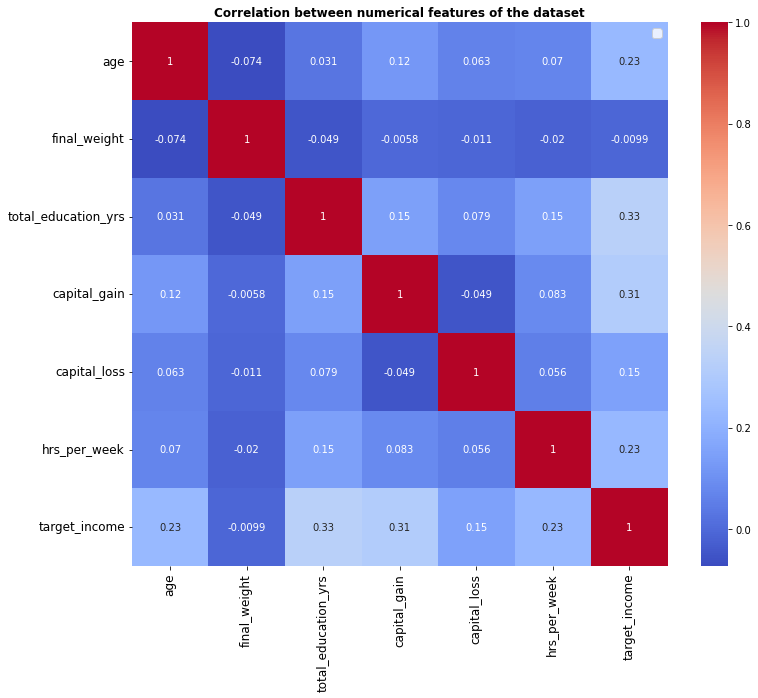

In [10]:
plt.figure(figsize = (12,10))
plt.title("Correlation between numerical features of the dataset", fontsize = 12, fontweight = 'bold')
sns.heatmap(train_df.corr(), cmap = 'coolwarm', annot = True)
plt.xticks(fontsize=12, rotation = 90)
plt.yticks(fontsize=12, rotation = 0)
plt.legend(fontsize=12)

### Age

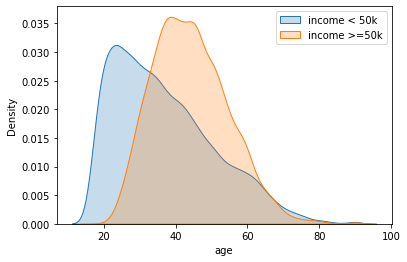

In [11]:
g = sns.kdeplot(data = train_df[train_df['target_income'] == 0]['age'], shade=True)
g = sns.kdeplot(data = train_df[train_df['target_income'] == 1]['age'], shade=True)
g = g.legend(["income < 50k","income >=50k"])

### Total education yrs

In [12]:
train_df[['total_education_yrs', 'target_income']].groupby(['total_education_yrs'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,total_education_yrs,target_income
15,16,0.721477
14,15,0.698113
13,14,0.548780
12,13,0.411882
10,11,0.257089
11,12,0.244848
9,10,0.189156
8,9,0.157136
7,8,0.069069
5,6,0.066025


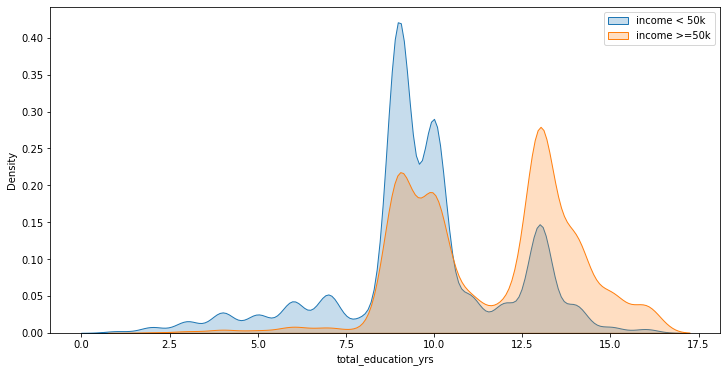

In [13]:
plt.figure(figsize= (12,6))
g = sns.kdeplot(data = train_df[train_df['target_income'] == 0]['total_education_yrs'], shade=True)
g = sns.kdeplot(data = train_df[train_df['target_income'] == 1]['total_education_yrs'], shade=True)
g = g.legend(["income < 50k","income >=50k"])

### Capital gain (people who has capital_gain == 99999 always has income >= 50k)

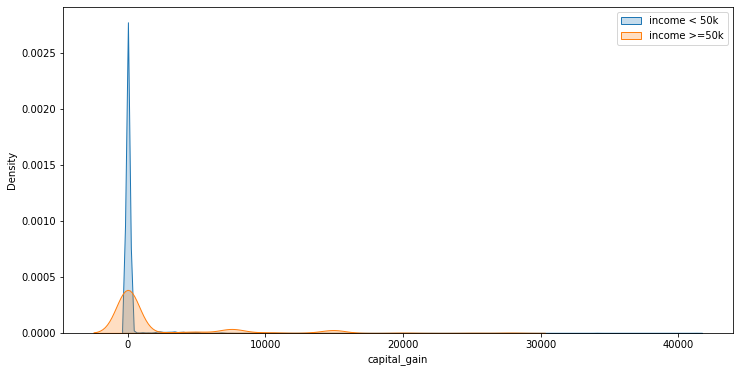

In [14]:
plt.figure(figsize= (12,6))
g = sns.kdeplot(data = train_df[train_df['target_income'] == 0]['capital_gain'], shade=True)
g = sns.kdeplot(data = train_df[train_df['target_income'] == 1]['capital_gain'], shade=True)
g = g.legend(["income < 50k","income >=50k"])

In [15]:
train_df[train_df.capital_gain > 25000].capital_gain.value_counts()

27828    28
25236    10
34095     4
25124     4
41310     2
Name: capital_gain, dtype: int64

 **Does capital_gain over 25k mean income is over 50k? \
 Answer: No**

In [16]:
train_df[train_df.capital_gain > 25000].target_income.mean()

0.875

### Capital loss

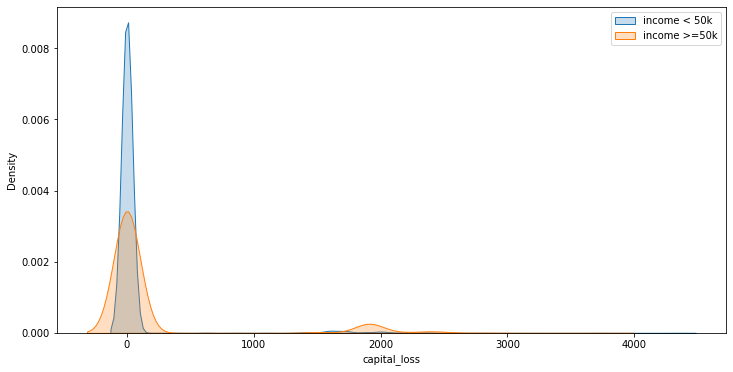

In [17]:
plt.figure(figsize= (12,6))
g = sns.kdeplot(data = train_df[train_df['target_income'] == 0]['capital_loss'], shade=True)
g = sns.kdeplot(data = train_df[train_df['target_income'] == 1]['capital_loss'], shade=True)
g = g.legend(["income < 50k","income >=50k"])

### hrs_per_week

**hrs_per_week has some values == 99 which is abnormal**

In [18]:
sum(train_df[train_df['target_income'] == 1]['hrs_per_week'] ==99)

18

 **Does hrs_per_week = 99 mean income is over 50k? \
 Answer: No**

In [19]:
train_df[train_df.hrs_per_week == 99].target_income.mean()

0.28125

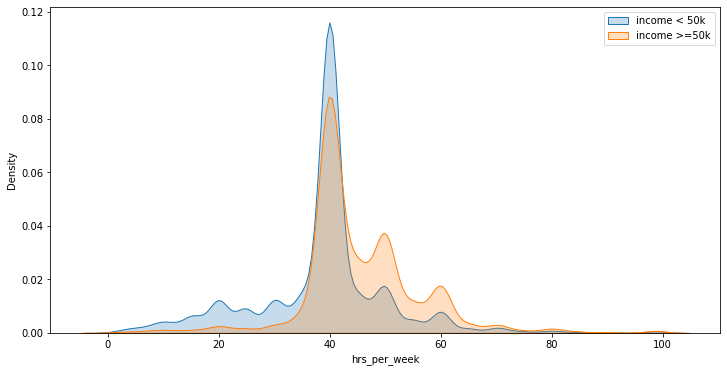

In [20]:
plt.figure(figsize= (12,6))
g = sns.kdeplot(data = train_df[train_df['target_income'] == 0]['hrs_per_week'], shade=True)
g = sns.kdeplot(data = train_df[train_df['target_income'] == 1]['hrs_per_week'], shade=True)
g = g.legend(["income < 50k","income >=50k"])

## Categorical features

In [21]:
train_df[['education','total_education_yrs' , 'target_income']].groupby(['education', 'total_education_yrs'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,education,total_education_yrs,target_income
10,Doctorate,16,0.721477
14,Prof-school,15,0.698113
12,Masters,14,0.548780
9,Bachelors,13,0.411882
8,Assoc-voc,11,0.257089
7,Assoc-acdm,12,0.244848
15,Some-college,10,0.189156
11,HS-grad,9,0.157136
2,12th,8,0.069069
0,10th,6,0.066025


### work_type

In [22]:
train_df[['work_type', 'target_income']].groupby(['work_type'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,work_type,target_income
4,Self-emp-inc,0.537530
0,Federal-gov,0.366621
1,Local-gov,0.291562
5,Self-emp-not-inc,0.277342
6,State-gov,0.264523
3,Private,0.215488
2,Never-worked,0.000000
7,Without-pay,0.000000


### sex

In [23]:
train_df[['sex','target_income']].groupby(['sex'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,sex,target_income
1,M,0.300470
0,F,0.106401


Text(0, 0.5, 'Target income probability')

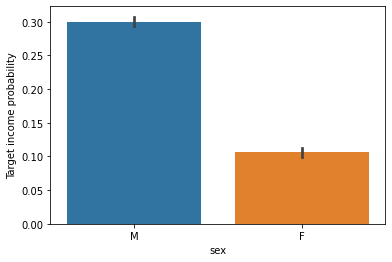

In [24]:
sns.barplot(x='sex', y='target_income', data = train_df)
plt.ylabel("Target income probability")

### ethnicity

In [25]:
train_df[['ethnicity', 'target_income']].groupby(['ethnicity'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,ethnicity,target_income
1,Asian-Pac-Islander,0.254215
4,White,0.251292
0,Amer-Indian-Eskimo,0.128099
2,Black,0.116660
3,Other,0.075758


### status

In [26]:
train_df[['status', 'target_income']].groupby(['status'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,status,target_income
5,Wife,0.469748
0,Husband,0.443924
1,Not-in-family,0.098203
4,Unmarried,0.062760
2,Other-relative,0.031088
3,Own-child,0.011533


### job

In [27]:
train_df['job'].value_counts()

Craft-repair         3139
Prof-specialty       3081
Exec-managerial      3056
Adm-clerical         2904
Sales                2812
Other-service        2597
Machine-op-inspct    1554
Transport-moving     1209
Handlers-cleaners    1046
Farming-fishing       766
Tech-support          725
Protective-serv       494
Priv-house-serv       111
Armed-Forces            8
Name: job, dtype: int64

In [28]:
train_df[['job', 'target_income']].groupby(['job'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,job,target_income
3,Exec-managerial,0.475131
9,Prof-specialty,0.435248
10,Protective-serv,0.325911
12,Tech-support,0.304828
11,Sales,0.264936
2,Craft-repair,0.225868
13,Transport-moving,0.211745
0,Adm-clerical,0.131198
6,Machine-op-inspct,0.126770
1,Armed-Forces,0.125000


### marital_state

In [29]:
train_df[['marital_state', 'target_income']].groupby(['marital_state'], as_index=False).mean().sort_values(by='target_income', ascending=False)

,marital_state,target_income
2,Married-civ-spouse,0.441703
1,Married-AF-spouse,0.437500
0,Divorced,0.102376
6,Widowed,0.085752
3,Married-spouse-absent,0.074534
5,Separated,0.061460
4,Never-married,0.042154


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Married-civ-spouse'),
  Text(1, 0, 'Never-married'),
  Text(2, 0, 'Divorced'),
  Text(3, 0, 'Widowed'),
  Text(4, 0, 'Separated'),
  Text(5, 0, 'Married-spouse-absent'),
  Text(6, 0, 'Married-AF-spouse')])

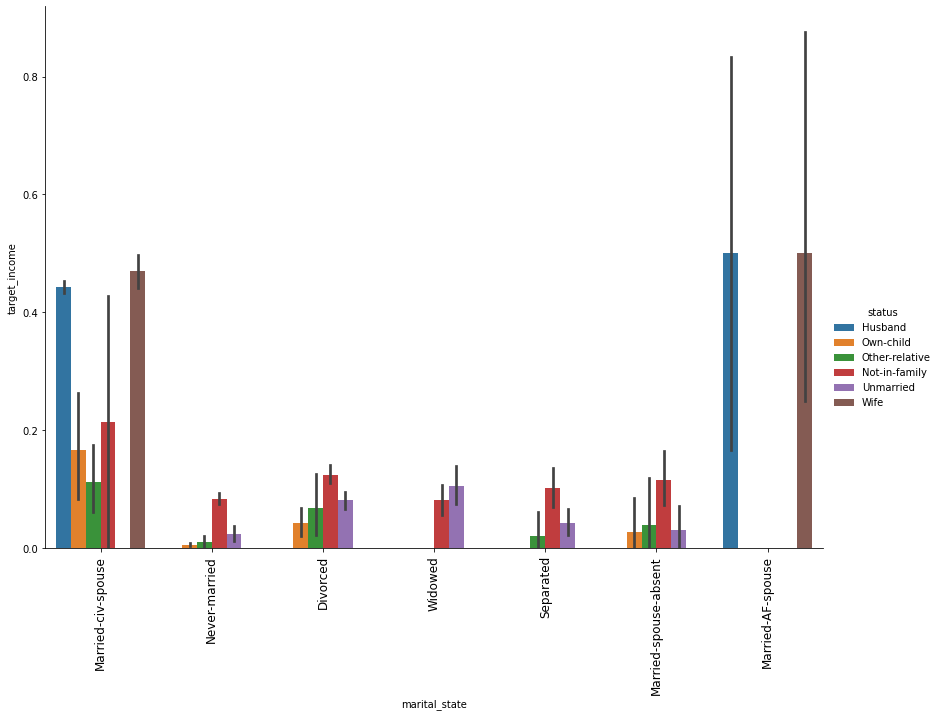

In [30]:
sns.catplot(x= 'marital_state', y='target_income', kind='bar', hue='status', data = train_df,height=8.27, aspect=11.7/8.27)
plt.xticks(fontsize=12, rotation = 90)

### nationality

In [31]:
train_df[['nationality', 'target_income']].groupby(['nationality'], as_index=False).mean().sort_values(by='target_income', ascending=False).nationality.to_numpy()

array(['France', 'Cambodia', 'Taiwan', 'Yugoslavia', 'Iran', 'India',
       'Japan', 'Italy', 'China', 'Germany', 'Philippines', 'Canada',
       'Scotland', 'Cuba', 'England', 'US', 'Hong', 'Poland', 'Ireland',
       'Thailand', 'Hungary', 'Greece', 'Laos', 'South', 'Ecuador',
       'Trinadad&Tobago', 'Jamaica', 'Haiti', 'Puerto-Rico',
       'El-Salvador', 'Portugal', 'Vietnam', 'Mexico', 'Columbia',
       'Guatemala', 'Nicaragua', 'Honduras', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Holand-Netherlands',
       'Dominican-Republic'], dtype=object)

## Numerical versus categorical features

In [32]:
train_df[['job', 'hrs_per_week']].groupby(['job'], as_index=False).median().sort_values(by='hrs_per_week', ascending=False)

,job,hrs_per_week
0,Adm-clerical,40.0
1,Armed-Forces,40.0
2,Craft-repair,40.0
3,Exec-managerial,40.0
4,Farming-fishing,40.0
5,Handlers-cleaners,40.0
6,Machine-op-inspct,40.0
7,Other-service,40.0
9,Prof-specialty,40.0
10,Protective-serv,40.0


In [33]:
train_df[['job', 'total_education_yrs']].groupby(['job'], as_index=False).median().sort_values(by='total_education_yrs', ascending=False)

,job,total_education_yrs
9,Prof-specialty,13.0
3,Exec-managerial,12.0
12,Tech-support,11.0
0,Adm-clerical,10.0
10,Protective-serv,10.0
11,Sales,10.0
1,Armed-Forces,9.0
2,Craft-repair,9.0
4,Farming-fishing,9.0
5,Handlers-cleaners,9.0


In [34]:
train_df[['job', 'capital_gain']].groupby(['job']).mean().sort_values(by='capital_gain', ascending=False)

,capital_gain
job,
Exec-managerial,1227.111911
Prof-specialty,1091.130802
Sales,658.881579
Farming-fishing,633.345953
Tech-support,618.513103
Protective-serv,462.663968
Transport-moving,458.928040
Craft-repair,451.509716
Adm-clerical,344.932851


In [35]:
train_df[['work_type', 'hrs_per_week']].groupby(['work_type'], as_index=False).mean().sort_values(by='hrs_per_week', ascending=False)

,work_type,hrs_per_week
4,Self-emp-inc,48.824455
5,Self-emp-not-inc,44.374150
0,Federal-gov,41.166895
1,Local-gov,40.799118
3,Private,40.176110
6,State-gov,38.962656
7,Without-pay,35.100000
2,Never-worked,31.800000


In [36]:
train_df[['work_type', 'total_education_yrs']].groupby(['work_type'], as_index=False).median().sort_values(by='total_education_yrs', ascending=False)

,work_type,total_education_yrs
6,State-gov,11.0
0,Federal-gov,10.0
1,Local-gov,10.0
3,Private,10.0
4,Self-emp-inc,10.0
5,Self-emp-not-inc,10.0
2,Never-worked,9.0
7,Without-pay,9.0


# Feature engineering

## Correcting by dropping features

In [37]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
for dataset in combine:
    dataset.drop(['final_weight'], axis=1, inplace=True)
    dataset.drop(['education'], axis=1, inplace=True)
    #dataset.drop(['nationality'], axis=1, inplace=True)
print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (24884, 15) (7561, 14) (24884, 15) (7561, 14)
After (24884, 13) (7561, 12) (24884, 13) (7561, 12)


## Create new feature combining existing features

### Create has capital change feature

In [38]:
for dataset in combine:
    dataset['has_capital_change'] = abs(dataset['capital_gain'] - dataset['capital_loss']) > 0
    dataset['has_capital_change'] = dataset['has_capital_change'].astype(int)

### Create age-band feature

In [39]:
# for dataset in combine:    
#     dataset.loc[(dataset['age'] >16) & (dataset['age'] <= 20), 'age'] = 0
#     dataset.loc[(dataset['age'] > 20) & (dataset['age'] <= 37), 'age'] = 1
#     dataset.loc[(dataset['age'] > 40) & (dataset['age'] <= 60), 'age'] = 2
#     dataset.loc[(dataset['age'] > 60) & (dataset['age'] <= 75), 'age'] = 3
#     dataset.loc[(dataset['age'] > 60), 'age'] = 3

## Fill missing values

### Fill job column by the mode of total_education_years column

In [40]:
train_df.groupby('total_education_yrs').apply(lambda df: df['job'].mode()[0])

total_education_yrs
1      Other-service
2      Other-service
3      Other-service
4       Craft-repair
5       Craft-repair
6      Other-service
7      Other-service
8      Other-service
9       Craft-repair
10      Adm-clerical
11      Craft-repair
12      Adm-clerical
13    Prof-specialty
14    Prof-specialty
15    Prof-specialty
16    Prof-specialty
dtype: object

In [41]:
for dataset in combine:
    index_nan_job = list(dataset["job"][dataset["job"].isnull()].index)
    for nan_idx in index_nan_job:
        if dataset.iloc[nan_idx]['total_education_yrs'] in [1,2,3,6,7,8]:
            dataset['job'].iloc[nan_idx] = 'Other-service'
        if dataset.iloc[nan_idx]['total_education_yrs'] in [4,5,9,11]:
            dataset['job'].iloc[nan_idx] = 'Craft-repair'
        if dataset.iloc[nan_idx]['total_education_yrs'] in [10,12]:
            dataset['job'].iloc[nan_idx] = 'Adm-clerical'
        if dataset.iloc[nan_idx]['total_education_yrs'] in [13,14,15,16]:
            dataset['job'].iloc[nan_idx] = 'Prof-specialty'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Create mean_capital_gain group by job feature

In [42]:
temp = train_df.groupby('job')['capital_gain'].agg(['mean']).rename({'mean':'capital_gain_job_mean'},axis=1)
train_df = pd.merge(train_df,temp, on='job', how='left')
test_df = pd.merge(test_df, temp, on='job', how='left')
combine = [train_df, test_df]

In [43]:
print('Train columns with null values:\n', train_df.isnull().sum())
print("-"*40)
print('Test/Validation columns with null values:\n', test_df.isnull().sum())

Train columns with null values:
 age                         0
work_type                1377
total_education_yrs         0
marital_state               0
job                         0
status                      0
ethnicity                   0
sex                         0
capital_gain                0
capital_loss                0
hrs_per_week                0
nationality               436
target_income               0
has_capital_change          0
capital_gain_job_mean       0
dtype: int64
----------------------------------------
Test/Validation columns with null values:
 age                        0
work_type                457
total_education_yrs        0
marital_state              0
job                        0
status                     0
ethnicity                  0
sex                        0
capital_gain               0
capital_loss               0
hrs_per_week               0
nationality              140
has_capital_change         0
capital_gain_job_mean      0
dtype: int64


### Other categorical features

In [44]:
cat_cols = ['work_type', 'nationality']
for col in cat_cols:
    col_mode = train_df[col].mode()[0]
    for dataset in combine:
        dataset[col].fillna(col_mode, inplace=True)
print(train_df.isnull().sum())
print("-"*30)
print(test_df.isnull().sum())

age                      0
work_type                0
total_education_yrs      0
marital_state            0
job                      0
status                   0
ethnicity                0
sex                      0
capital_gain             0
capital_loss             0
hrs_per_week             0
nationality              0
target_income            0
has_capital_change       0
capital_gain_job_mean    0
dtype: int64
------------------------------
age                      0
work_type                0
total_education_yrs      0
marital_state            0
job                      0
status                   0
ethnicity                0
sex                      0
capital_gain             0
capital_loss             0
hrs_per_week             0
nationality              0
has_capital_change       0
capital_gain_job_mean    0
dtype: int64


### Create job_worktype feature

In [45]:
train_df['job_worktype'] = train_df['job'].astype(str)+ '_' + train_df['work_type'].astype(str)
test_df['job_worktype'] = test_df['job'].astype(str)+ '_' + test_df['work_type'].astype(str)

## Encode categorical features

### Encode nationality feature

In [46]:
group_1 = np.array(['France', 'Cambodia', 'Taiwan', 'Yugoslavia', 'Iran', 'India',
       'Japan'])
group_2 = np.array(['Italy', 'China', 'Germany', 'Philippines', 'Canada',
       'Scotland', 'Cuba', 'England', 'US', 'Hong', 'Poland', 'Ireland'])
group_3 = np.array(['Thailand', 'Hungary', 'Greece', 'Laos', 'South', 'Ecuador',
       'Trinadad&Tobago', 'Jamaica', 'Haiti', 'Puerto-Rico',
       'El-Salvador', 'Portugal', 'Vietnam', 'Mexico', 'Columbia',
       'Guatemala', 'Nicaragua', 'Honduras', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Holand-Netherlands',
       'Dominican-Republic'])
def nationality_to_numeric(nationality):
    if nationality in group_1:
        return 0
    if nationality in group_2:
        return 1
    if nationality in group_3:
        return 2
for dataset in combine:
    dataset['nationality'] = dataset['nationality'].apply(lambda nationality : nationality_to_numeric(nationality))

# Prepare train and test data

In [47]:
X_train = train_df.drop(['target_income'], axis=1)
y_train = train_df['target_income'].copy()
X_test = test_df.copy()

In [48]:
X_train.head()

,age,work_type,total_education_yrs,marital_state,job,status,ethnicity,sex,capital_gain,capital_loss,hrs_per_week,nationality,has_capital_change,capital_gain_job_mean,job_worktype
0,45,Private,9,Married-civ-spouse,Craft-repair,Husband,White,M,0,0,40,1,0,423.777444,Craft-repair_Private
1,23,Private,10,Never-married,Handlers-cleaners,Own-child,White,M,0,0,30,1,0,212.802103,Handlers-cleaners_Private
2,22,Private,10,Never-married,Prof-specialty,Other-relative,Asian-Pac-Islander,F,0,0,20,2,0,1112.002133,Prof-specialty_Private
3,27,Private,15,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,M,0,0,40,1,0,1112.002133,Prof-specialty_Private
4,18,Private,7,Never-married,Sales,Own-child,White,F,0,0,20,1,0,658.881579,Sales_Private


In [49]:
X_test.head()

,age,work_type,total_education_yrs,marital_state,job,status,ethnicity,sex,capital_gain,capital_loss,hrs_per_week,nationality,has_capital_change,capital_gain_job_mean,job_worktype
0,59,Self-emp-not-inc,15,Married-civ-spouse,Sales,Husband,White,M,0,0,25,1,0,658.881579,Sales_Self-emp-not-inc
1,41,Private,9,Married-civ-spouse,Craft-repair,Husband,White,M,0,0,40,1,0,423.777444,Craft-repair_Private
2,66,Self-emp-not-inc,4,Widowed,Farming-fishing,Unmarried,White,M,0,0,50,1,0,633.345953,Farming-fishing_Self-emp-not-inc
3,29,Private,11,Never-married,Sales,Not-in-family,Black,M,0,0,45,1,0,658.881579,Sales_Private
4,35,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,M,0,1848,70,1,1,1227.111911,Exec-managerial_Private


## Encode categorical features

### Label encoder

In [50]:
from sklearn import preprocessing
categorical = [col for col in X_train.columns if X_train[col].dtype == 'O']
print(categorical)
for feature in categorical:
        le = preprocessing.LabelEncoder()
        df = pd.concat([X_train[feature],X_test[feature]],axis=0)
        # PERFORM FEATURE ENGINEERING HERE
        df = le.fit_transform(df)
        X_train[feature] = df[:len(X_train)]
        X_test[feature] = df[len(X_train):]
        #X_train[feature] = le.fit_transform(X_train[feature])
        #X_test[feature] = le.transform(X_test[feature])

['work_type', 'marital_state', 'job', 'status', 'ethnicity', 'sex', 'job_worktype']


### One-hot encoder

**One hot encoder by pandas**

In [51]:
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)

# XGB baseline

In [52]:
from sklearn.metrics import f1_score
def compute_f1(predicted, label, threshold=0.5):
    label = label.get_label()
    y_bin = (predicted >= threshold).astype(int)
    return "f1", f1_score(label, y_bin)

In [53]:
from xgboost import XGBClassifier
xgb_params = {
    'objective': 'binary:logistic',
    'n_estimators' : 1000,
    'eval_metric' : 'error',
    'learning_rate' : 0.05,
    'random_state' : SEED,
    'subsample': 0.8,
    'colsample_bytree':0.8,
    #'disable_default_eval_metric' : 1,
}

In [54]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)
oof = np.zeros(len(X_train))
preds = np.zeros((len(X_test),2))
feature_imp_list = np.zeros(len(X_train.columns))
for idx, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), start=1):
    xgb_classifier = XGBClassifier(**xgb_params, use_label_encoder=False)
    print('Fold', idx, 'rows of train =',len(train_idx),'rows of holdout =',len(valid_idx))
    h = xgb_classifier.fit(X_train.iloc[train_idx], y_train.iloc[train_idx],
                           eval_set=[(X_train.iloc[valid_idx], y_train.iloc[valid_idx])],
                           verbose=100,early_stopping_rounds=100)
    oof[valid_idx] = xgb_classifier.predict(X_train.iloc[valid_idx])
    #Bootstrap aggregation 
    preds += xgb_classifier.predict_proba(X_test)/skf.n_splits
    #Feature importants
    feature_imp_list += xgb_classifier.feature_importances_/skf.n_splits
    del h, xgb_classifier
    x=gc.collect()
    print()
print('#'*40)
print('XGB OOF CV=',f1_score(y_train, oof))

Fold 1 rows of train = 22395 rows of holdout = 2489
[0]	validation_0-error:0.15548
[100]	validation_0-error:0.13419
[200]	validation_0-error:0.13057
[300]	validation_0-error:0.13017
[386]	validation_0-error:0.13057

Fold 2 rows of train = 22395 rows of holdout = 2489
[0]	validation_0-error:0.15227
[100]	validation_0-error:0.13057
[200]	validation_0-error:0.12495
[300]	validation_0-error:0.12133
[391]	validation_0-error:0.12535

Fold 3 rows of train = 22395 rows of holdout = 2489
[0]	validation_0-error:0.15749
[100]	validation_0-error:0.12575
[200]	validation_0-error:0.11812
[300]	validation_0-error:0.12013
[301]	validation_0-error:0.11973

Fold 4 rows of train = 22395 rows of holdout = 2489
[0]	validation_0-error:0.15629
[100]	validation_0-error:0.14062
[200]	validation_0-error:0.13620
[300]	validation_0-error:0.13258
[375]	validation_0-error:0.13459

Fold 5 rows of train = 22396 rows of holdout = 2488
[0]	validation_0-error:0.15193
[100]	validation_0-error:0.12781
[200]	validation_0-e

## Feature important

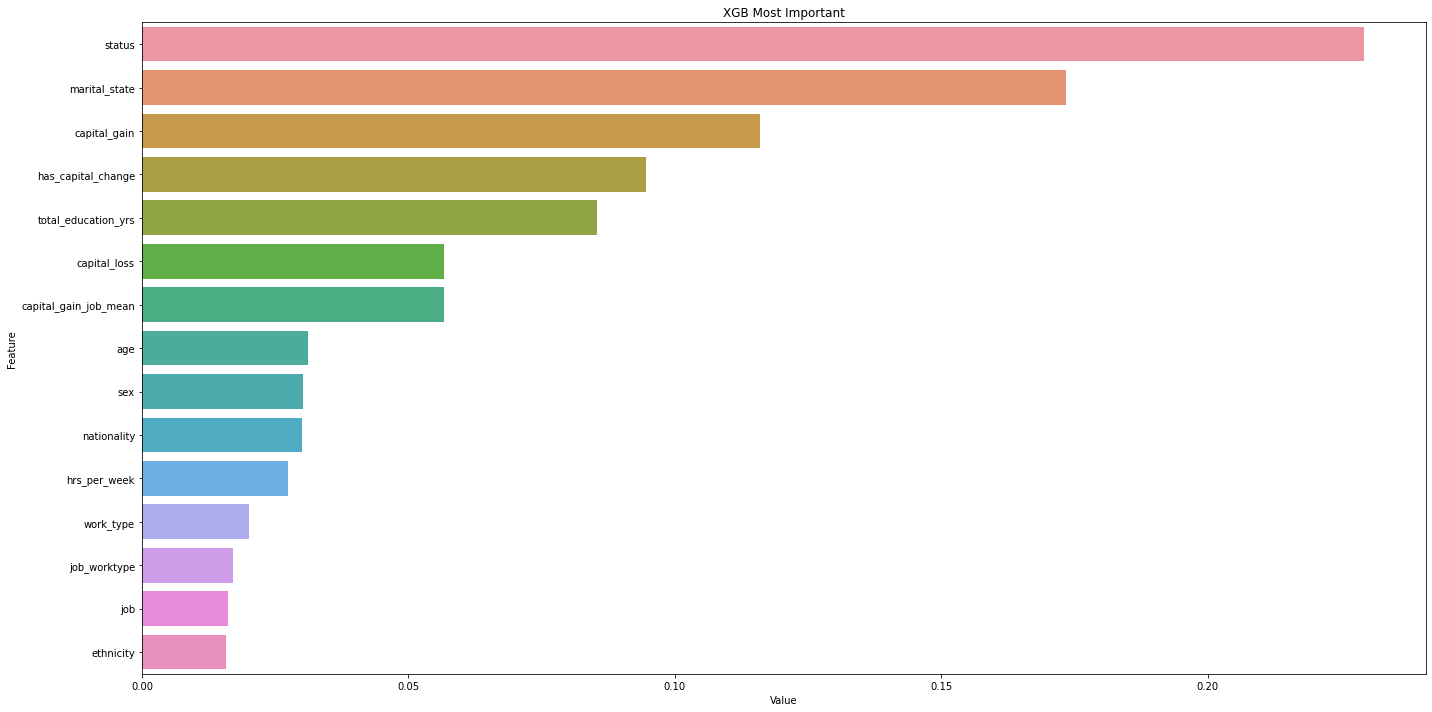

In [55]:
feature_imp = pd.DataFrame(sorted(zip(feature_imp_list,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:])
plt.title('XGB Most Important')
plt.tight_layout()
plt.show()

# Submission

In [56]:
#sample_sub['target_income'] = (preds >= 0.5).astype(int)
sample_sub['target_income'] = np.argmax(preds, axis=1)
sample_sub

,ID,target_income
0,25000,1
1,25001,0
2,25002,0
3,25003,0
4,25004,1
...,...,...
7556,32556,1
7557,32557,1
7558,32558,0
7559,32559,1


In [57]:
test_leak = (test_df['capital_gain'] == 99999).to_numpy()

In [58]:
sample_sub['target_income'].loc[test_leak] = 1

In [59]:
sample_sub
sample_sub.to_csv('submission.csv', index=False)

In [60]:
sample_sub['target_income'].sum()

1559